In [ ]:
!pip install contextily

import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib
import contextily as cx
import geopandas as gpd
from datetime import datetime
from sklearn.preprocessing import minmax_scale
from sklearn.cluster import KMeans
import re


drive.mount('/content/gdrive')

#Let's change into the directory on Google Drive that we uploaded this notebook and the data to:
%cd /content/gdrive/MyDrive/COMP790/
!ls # special shell command to view the files in the home directory of the notebook environment

In [ ]:
#reading in the json

df = pd.read_json("Zillow-ChapelHill-Spring2023-18k-Properties.json", orient='columns')

print(df.head())

In [ ]:
#Prints the shape prior to the first cut of data
print(df.shape)

#Keeping only the rows from the DataFrame that have Chapel Hill as the city, and NC as the state.
df = df[(df['address'].str['city'].str.casefold() == 'chapel hill') & (df['address'].str['state'] == 'NC')]
#df.reset_index(drop=True, inplace=True)

#Create a list of the homeTypes we want to keep, then keep only the rows of that type
typeMask = ['SINGLE_FAMILY','CONDO','TOWNHOUSE']
df = df[df['homeType'].isin(typeMask)]

#Now we drop the listings that contain no mortgage data
df = df[~df['mortgageRates'].isnull()]

#Drop the couple listings that have no location data
df = df[~df['latitude'].isnull()]

#Drop listings without actual mortgage data
df = df[~df['mortgageRates'].str['thirtyYearFixedRate'].isnull()]

#After removing the data we reset the indexes so that we don't have any gaps
df.reset_index(drop=True, inplace=True)

#Prints the shape after first cut
print(df.shape)

#print(df.info())

In [ ]:
# Assuming 'df' is your DataFrame
# Define the threshold for dropping columns
threshold_non_null = 14200

# Calculate the number of non-null values for each column
non_null_counts = df.notnull().sum()

# Identify columns to drop based on the threshold, specifically excluding 'bedrooms' and 'mortgageRates'
# Note the corrected logical operation to exclude both 'bedrooms' and 'mortgageRates'
columns_to_drop = non_null_counts[(non_null_counts < threshold_non_null) & ~(non_null_counts.index.isin(['bedrooms', 'mortgageRates', 'dateSoldString', 'dateSold', 'zestimate', 'lastSoldPrice']))].index

# Create a DataFrame with only the columns to be dropped
dropped_columns_df = df[columns_to_drop]

# Print or display the DataFrame with the dropped columns for inspection
print("DataFrame of columns to be dropped:")
display(dropped_columns_df.info())  # Using display() for nicer formatting in Jupyter Notebooks, use print() if not in Jupyter

# Drop these columns from the original DataFrame
df_reduced = df.drop(columns=columns_to_drop)

df_reduced = df_reduced.drop(columns=['description', 'photos', 'tourEligibility', ])

# Check to ensure 'bedrooms' and 'mortgageRates' are included in the reduced DataFrame
print("\nReduced DataFrame info:")
print(df_reduced.info())



In [ ]:
# prompt: creating a geodataframe containing the latitude/longitude of each datum, as well as the ID and price.

# Create a GeoDataFrame from the existing DataFrame, We can include more than just the price and ZPID in the GeoDataFrame if needed
geometry = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df[['zpid', 'price', 'mortgageRates', 'dateSoldString', 'dateSold','abbreviatedAddress', 'priceHistory', 'propertyTaxRate']], geometry=geometry)

# Display the head of the GeoDataFrame
print(gdf.info())


In [ ]:
#Just looking at the spread of price values
display(gdf['price'].describe())

#Checking to see how many mortgageRate objects have no value
print(gdf['mortgageRates'].str['thirtyYearFixedRate'].isnull().value_counts())

#Uncomment out the code below to filter out aforementioned rows without a mortgageRate number, currently we are filtering out this data above so we don't need the line
#gdf = gdf[~gdf['mortgageRates'].str['thirtyYearFixedRate'].isnull()]

gdf['rate'] = gdf['mortgageRates'].str['thirtyYearFixedRate']


In [ ]:
#Create new dataframe to work with towards k-means clustering, both with clust_df and a later GeoDataFrame
clust_df = df_reduced[['price', 'mortgageRates', 'dateSold', 'abbreviatedAddress', 'longitude', 'latitude']]

#Add a mortgage rate column then drop 'mortgageRates'
clust_df['rate'] = clust_df.loc[:,('mortgageRates')].str['thirtyYearFixedRate']
clust_df = clust_df.drop(['mortgageRates'], axis=1)

#Remove rows without a dateSold entry and reset indexes
clust_df = clust_df[~clust_df['dateSold'].isnull()]
clust_df.reset_index(drop=True, inplace=True)

#Create a timeOwned column based on the elapsed time since dateSold
clust_df['timeOwned'] = clust_df['dateSold'].apply(timediff)
clust_df = clust_df.drop(['dateSold'], axis=1)


#Grab the features we want to cluster data on, which in this case is just latitude and longitude
X = clust_df.drop(['abbreviatedAddress','price','rate','timeOwned'], axis=1).values

#Scale that data between 0 and 1
X_scaled = minmax_scale(X)

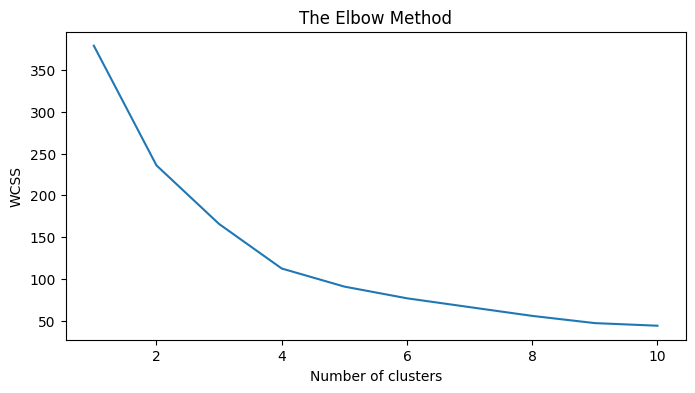

In [37]:
#Below code borrows heavily from what we did in class

# 2. Create an empty list to hold Within Cluster Sum of Squares (WCSS)
wcss = []

# 3. Run k-means multiple times (here 11) with k = 1 to 11 and record WCSS (using .inertia_)
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init = "auto", random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 4. Plot WCSS against k in a line graph and look for 'The Elbow'
plt.rcParams['figure.figsize'] = (8, 4)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [ ]:
#Instantiate and fit model with the data
kmeans = KMeans(n_clusters=7, init = 'k-means++', max_iter = 300, n_init = "auto", random_state = 42)
kmeans = kmeans.fit(X_scaled)

#Use model to predict clusters
labels = kmeans.predict(X_scaled)

#Add cluster labels to dataframe
clust_df['label'] = labels+1
clust_df.label.value_counts()


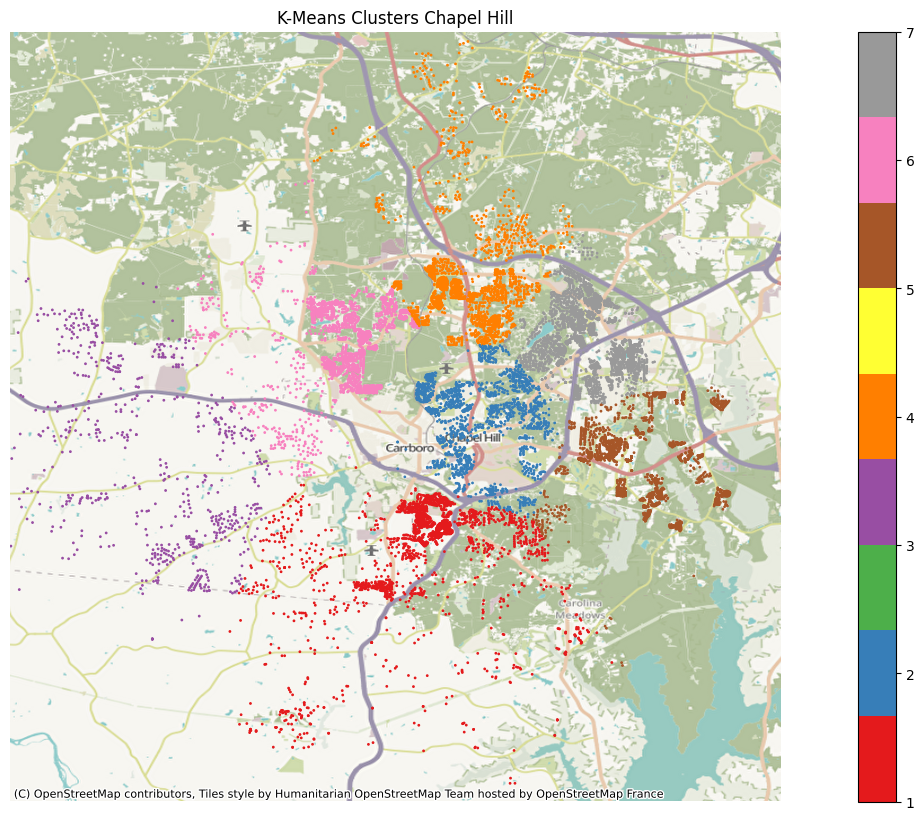

In [39]:
extent = (-79.20, -78.96, 35.80, 36.04)
extent2 = (-79.135, -78.968, 35.85, 36.00)

geometry = gpd.points_from_xy(clust_df['longitude'], clust_df['latitude'])
clust_gdf = gpd.GeoDataFrame(clust_df[['label']], geometry=geometry)

ax = clust_gdf.plot(column='label', cmap='Set1', markersize=1, legend=True)

#Set title
ax.set_title('K-Means Clusters Chapel Hill')
ax.axis(extent)
ax.set_axis_off()

#Gets the current figure and sets the size to something larger than default. Probably a cleaner way to do this
plt.gcf().set_size_inches(20,10)

#Adding a basemap to our axes object and giving it the crs of our data
cx.add_basemap(ax, interpolation='sinc' ,crs='EPSG:4326', zoom=12)

#Displaying the plot
plt.show()

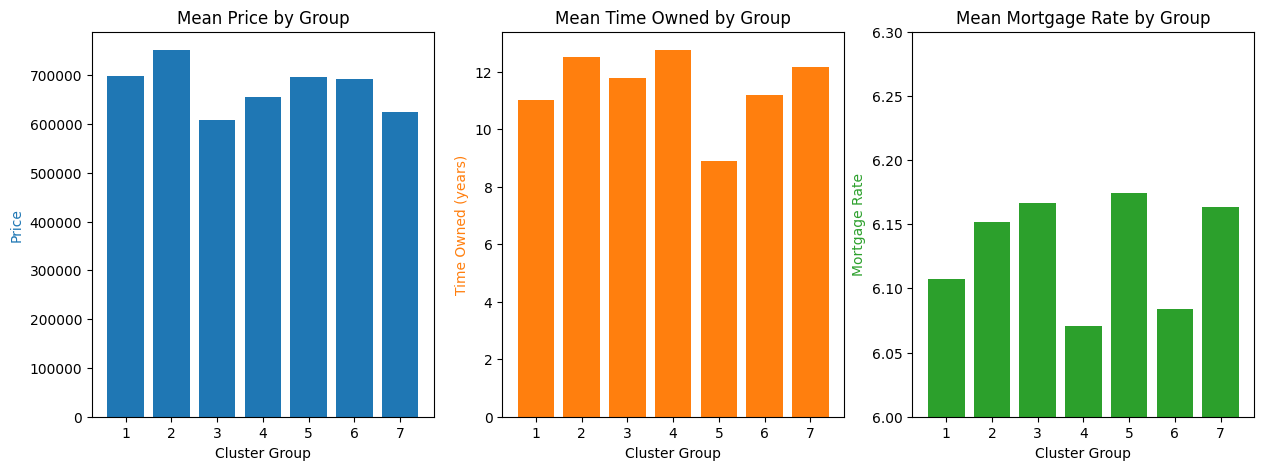

In [40]:
# Create a grouped bar chart with multiple axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Configure the first axis for 'price'
ax1.bar(clust_df.groupby('label')['price'].mean().index, clust_df.groupby('label')['price'].mean(), color='tab:blue')
ax1.set_ylabel('Price', color='tab:blue')
ax1.set_xlabel('Cluster Group')
ax1.set_title('Mean Price by Group')

# Configure the second axis for 'timeOwned'
ax2.bar(clust_df.groupby('label')['timeOwned'].mean().index, clust_df.groupby('label')['timeOwned'].mean(), color='tab:orange')
ax2.set_ylabel('Time Owned (years)', color='tab:orange')
ax2.set_xlabel('Cluster Group')
ax2.set_title('Mean Time Owned by Group')

# Configure the third axis for 'rate'
ax3.bar(clust_df.groupby('label')['rate'].mean().index, clust_df.groupby('label')['rate'].mean(), color='tab:green')
ax3.set_ylim(6, 6.3)
ax3.set_ylabel('Mortgage Rate', color='tab:green')
ax3.set_xlabel('Cluster Group')
ax3.set_title('Mean Mortgage Rate by Group')

# Show the plot
plt.show()